## 0. Set up preparation

### Auto-Reload

In [1]:
%load_ext autoreload
%autoreload 2
# 파이썬 코드를 실행하기 전에 항상 모든 모듈을 Reload

### Add a module path

In [2]:
import os
import sys

In [ ]:
# This command returns the absolute path of the folder where Jupyter is running. If you want to use a different path instead of the Jupyter folder, please modify it.
jupyter_run_dir = os.getcwd()
print(f'The current active folder is "{jupyter_run_dir}".\n')

# module path
module_dir = jupyter_run_dir + '/Image-to-NPZ_dataset'

sys.path.append(module_dir)
print(sys.path[-1])

In [4]:
import random
import numpy as np

def seed(seed = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

seed()

## 1. Image to Numpy

### Retrieve all image paths
> If you want to remove a specific phrase from filenames, you can use the following function (rename_the_files).   
> Please note that 'rename_the_files' takes a list of files and removes the 'remove_str' from all of them, then saves them again.   
> So, set 'remove_str' to a character or string that exists in all the files.   

In [5]:
from utils.utils import image_valid_check

In [ ]:
data_dir = '/mnt/7977asdasf/'
valid_reuslt = image_valid_check(data_dir, True)

Here are the Validation Check Results.
1. This file is not an image. -> count : 0
	e.g.None
2. This file is not in a format supported by TensorFlow OR Pytorch. -> count : 0
	e.g.None
3. This file is in a format supported by TensorFlow OR Pytorch. -> count : 746
	class - Normal -> count : 480
		e.g./mnt/7977asdasf/Normal/dde347148556b6fc8d5250064095d4ee.png
	class - Pancreatic -> count : 266
		e.g./mnt/7977asdasf/Pancreatic/3477a699f17d9260004472ef5810bccd.png)


### Convert the searched images into NumPy data

In [10]:
from utils.utils import make_a_numpy_dataset

##### Option 1. single-processing

In [ ]:
start = time.time()
dataset, classes = make_a_numpy_dataset(valid_reuslt['image'], image_W=400, image_H=800)
end = time.time()
print(f'\n Total time : {datetime.timedelta(seconds=(end-start))}')

classes, np.unique(dataset['label'], return_counts=True)

Convert the images to numpy...
Attempting to convert the 'Normal' class to a numpy array.
100%|█████████████████████████████████████████████████████████████████████████████████| 480/480 [17:59<00:00,  2.25s/it]
This Class is Normal. -> shape : (480, 800, 400, 4)

Attempting to convert the 'Pancreatic' class to a numpy array.
100%|█████████████████████████████████████████████████████████████████████████████████| 266/266 [09:15<00:00,  2.09s/it]
This Class is Pancreatic. -> shape : (266, 800, 400, 4)


Make a label...

Make a dataset...

0:30:30.385641


(['Normal', 'Pancreatic'], (array([0, 1]), array([480, 266])))

In [ ]:
len(dataset['data'])

746

##### Option 2. Multi-processing (Speeding up & Recommendation)

In [ ]:
from concurrent.futures import ProcessPoolExecutor
import multiprocessing

In [ ]:
# num_cores = multiprocessing.cpu_count() # 64 core -> Overhead...
num_cores = 12
num_cores

12

In [ ]:
splited_data_dict = {}
for class_name, path_list in valid_reuslt['image'].items():
    splited_data_dict[class_name] = np.array_split(path_list, num_cores)

splited_data = [{} for _ in range(num_cores)]
for class_name, splited_path_list in splited_data_dict.items():
    for num_core, path_list in enumerate(splited_path_list):
        splited_data[num_core][class_name] = path_list
        
len(splited_data), splited_data[0]['Normal'][:5], valid_reuslt['image']['Normal'][:5]

(12,
 array([PosixPath('/mnt/797cf4e7-1dc1-4e40-ac32-d4f55c462ff4/aima/dataset/PACA/without-split/img-231018/Normal/dde347148556b6fc8d5250064095d4ee.png'),
        PosixPath('/mnt/797cf4e7-1dc1-4e40-ac32-d4f55c462ff4/aima/dataset/PACA/without-split/img-231018/Normal/8d522569f563d1bcbfed83908dc11c11.png'),
        PosixPath('/mnt/797cf4e7-1dc1-4e40-ac32-d4f55c462ff4/aima/dataset/PACA/without-split/img-231018/Normal/f50675dad6bae512b79569f0f5510dc4.png'),
        PosixPath('/mnt/797cf4e7-1dc1-4e40-ac32-d4f55c462ff4/aima/dataset/PACA/without-split/img-231018/Normal/e40e0f05779235ea572a37fed2895625.png'),
        PosixPath('/mnt/797cf4e7-1dc1-4e40-ac32-d4f55c462ff4/aima/dataset/PACA/without-split/img-231018/Normal/53bb57cf53b9f10d2729aa932a456a75.png')],
       dtype=object),
 [PosixPath('/mnt/797cf4e7-1dc1-4e40-ac32-d4f55c462ff4/aima/dataset/PACA/without-split/img-231018/Normal/dde347148556b6fc8d5250064095d4ee.png'),
  PosixPath('/mnt/797cf4e7-1dc1-4e40-ac32-d4f55c462ff4/aima/dataset/PACA

In [ ]:
def pass_funcion(data):
    return make_a_numpy_dataset(data, image_W=400, image_H=800, single_processing=False)

start = time.time()
pool = ProcessPoolExecutor(max_workers=num_cores)
results = list(pool.map(pass_funcion, splited_data))
end = time.time()
print(f'\n Total time : {datetime.timedelta(seconds=(end-start))}')

100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:38<00:00,  1.69s/it]



 Total time : 0:01:47.497161


In [ ]:
dataset, classes =  {k:v for k, v in result[0][0].items()}, []

for r in results[1:]:
    d, classes = r
    # dataset = {k:np.concatenate((dataset[k], v), axis=0) for k, v in d.items()}
    for k, v in d.items():
        if type(v) == np.ndarray: dataset[k] = np.concatenate((dataset[k], v), axis=0)
        elif type(v) == dict:
            for class_name in classes:
                dataset[k][class_name] = np.concatenate((dataset[k][class_name], v[class_name]), axis=0)
        else: raise TypeError(f'The type returned is a dictionary or numpy ndarray.\nCurrent type is {type(v)}')

classes, np.unique(dataset['label'], return_counts=True), len(dataset['data'])

(['Normal', 'Pancreatic'], (array([0, 1]), array([480, 266])), 746)

### Check the data converted to numpy.

In [16]:
from utils.utils import show_data2img

In [34]:
check_index = [3, -5, -1]
check_items = []
for index in check_index:
    check_items.append([dataset['data'][index], dataset['label'][index]])
check_items[0], check_items[-1]

([array([[227, 227, 227, ..., 227, 227, 227],
         [227, 227, 227, ..., 227, 227, 227],
         [227, 227, 227, ..., 227, 227, 227],
         ...,
         [227, 227, 227, ..., 227, 227, 227],
         [227, 227, 227, ..., 227, 227, 227],
         [227, 227, 227, ..., 227, 227, 227]], dtype=uint8),
  0],
 [array([[229, 229, 229, ..., 229, 229, 229],
         [229, 229, 229, ..., 229, 229, 229],
         [229, 229, 229, ..., 229, 229, 229],
         ...,
         [229, 229, 229, ..., 229, 229, 229],
         [229, 229, 229, ..., 229, 229, 229],
         [229, 229, 229, ..., 229, 229, 229]], dtype=uint8),
  1])

Image shape: (800, 400, 4)


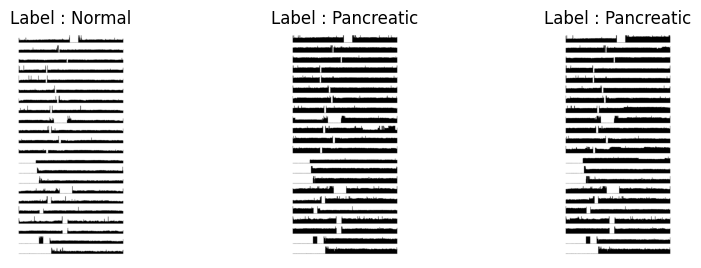

In [ ]:
show_data2img(check_items, classes)

## 2. Saving
> If you want to split and save the data directly, please refer to the `1-make_a_dataset.ipynb` file for instructions.

In [37]:
from utils.utils import save_numpy_dataset

In [44]:
save_dir = '/mnt/7977asdasf/npz'
save_numpy_dataset(dataset, classes, save_dir)

save... /mnt/7977asdasf/npz/img2npz.npz
